In [9]:
############## data segmentation
# Importing Necessary libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from sqlalchemy import create_engine

server = 'LAPTOP-LFBT0G3K'
database = 'DataWarehouse'
driver = '{ODBC Driver 18 for SQL Server}'


In [11]:
try:
    quoted_driver = urllib.parse.quote_plus(driver)
    connection_uri = (
        f'mssql+pyodbc:///?odbc_connect='
        f'DRIVER={quoted_driver};'
        f'SERVER={server};'
        f'DATABASE={database};'
        f'Trusted_Connection=yes;'
        f'Encrypt=yes;'
        f'TrustServerCertificate=yes;'
    )

    print(f"Attempting to connect to {server}/{database} using driver: {driver}")
    engine = create_engine(connection_uri)
    print("Successfully connected to SQL Server!")

    sql_analysis_query="""
                     with product_segments as(
                         SELECT
                             product_key,
                             product_name,
                             cost,
                             CASE
                                 WHEN cost<100 THEN 'Below 100'
                                 WHEN cost BETWEEN 100 and 500 THEN '100-500'
                                 WHEN cost BETWEEN 500 and 1000 THEN '500-1000'
                                 ELSE 'above 1000'
                             END as cost_range
                         FROM gold.dim_products
                     )
                     SELECT
                         cost_range,
                         COUNT(product_key) as total_products
                     FROM product_segments
                     GROUP BY cost_range
                     ORDER BY total_products DESC;
    """
    df_product_segment = pd.read_sql(sql_analysis_query, engine)


    sql_analysis_query="""
                     with customer_spending as(
                         SELECT
                             c.customer_key,
                             SUM(f.sales_amount) as total_spending,
                             MIN(order_date) as first_order,
                             max(order_date) as last_order,
                             datediff(month,MIN(order_date),MAX(order_date)) as lifespan

                         from gold.fact_sales f
                         LEFT JOIN gold.dim_customer c
                             ON f.customer_key = c.customer_key
                         GROUP BY c.customer_key
                     )
                     SELECT
                         customer_segment,
                         COUNT(customer_key) as total_customers
                     FROM (
                         SELECT
                             customer_key,
                             CASE
                                 WHEN lifespan>=12 and total_spending>5000 THEN 'VIP'
                                 WHEN lifespan>=12 and total_spending<=5000 THEN 'Regular'
                                 ELSE  'New'
                             END as customer_segment
                             from customer_spending
                     ) as segmented_customers
                     GROUP BY customer_segment
                     ORDER BY total_customers DESC;
    """
    df_customer_segment = pd.read_sql(sql_analysis_query, engine)

except Exception as e:
    print(f"An unexpected error occurred: {e}")

Attempting to connect to LAPTOP-LFBT0G3K/DataWarehouse using driver: {ODBC Driver 18 for SQL Server}
Successfully connected to SQL Server!


In [6]:
# Testing our data
print('first 5 rows fo sales analysis Data : ')
print(df_product_segment.head())
print('\nSales Analysis Data info : ')
print(df_product_segment.info())

first 5 rows fo sales analysis Data : 
   cost_range  total_products
0   Below 100             110
1     100-500             101
2    500-1000              45
3  above 1000              39

Sales Analysis Data info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   cost_range      4 non-null      object
 1   total_products  4 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes
None


In [12]:
# Testing our data
print('first 5 rows fo sales analysis Data : ')
print(df_customer_segment.head())
print('\nSales Analysis Data info : ')
print(df_customer_segment.info())

first 5 rows fo sales analysis Data : 
  customer_segment  total_customers
0              New            14631
1          Regular             2198
2              VIP             1655

Sales Analysis Data info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_segment  3 non-null      object
 1   total_customers   3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes
None


C:\Users\Ayush\AppData\Local\Temp\ipykernel_18968\245984079.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cost_range',y='total_products',data=df_product_segment,palette='deep')


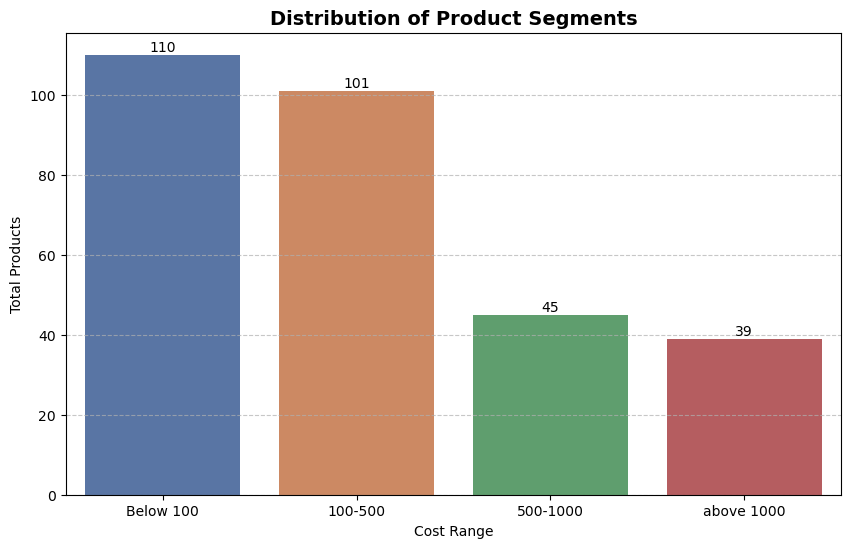

In [27]:
plt.figure(figsize=(10,6))
sns.barplot(x='cost_range',y='total_products',data=df_product_segment,palette='deep')
plt.xlabel('Cost Range')
plt.ylabel('Total Products')
plt.title('Distribution of Product Segments',fontsize=14,fontweight='bold')

for index,row in df_product_segment.iterrows():
    plt.text(index,row['total_products'],f"{row['total_products']}", color='black', ha="center", va='bottom')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\Ayush\AppData\Local\Temp\ipykernel_18968\1580675917.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='customer_segment',y='total_customers',data=df_customer_segment,palette='magma_r')


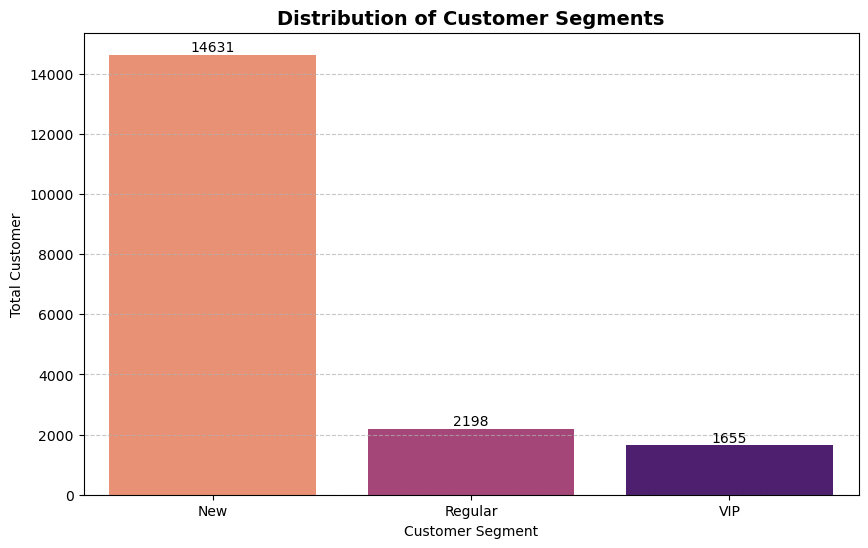

In [29]:
plt.figure(figsize=(10,6))
sns.barplot(x='customer_segment',y='total_customers',data=df_customer_segment,palette='magma_r')
plt.xlabel('Customer Segment')
plt.ylabel('Total Customer')
plt.title('Distribution of Customer Segments',fontsize=14,fontweight='bold')

for index,row in df_customer_segment.iterrows():
    plt.text(index,row['total_customers'],f"{row['total_customers']}", color='black', ha="center", va='bottom')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()